In [1]:
# from preproc_tools import get_fr_by_sample, to_python_hdf5
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from pathlib import Path
import h5py
from sklearn.svm import SVC
from scipy.spatial.distance import pdist
import pickle
import pandas as pd
from datetime import datetime
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.trials import  select_trials
from ephysvibe.trials.spikes import firing_rate
from typing import Dict, List
import tools_decoding
seed=1997

### Prepeare data for decoding

In [2]:
# import gc


# # importing the module
# import tracemalloc

# # starting the monitoring
# tracemalloc.start()
# print(tracemalloc.get_traced_memory())
# # function call
# # preprocessing 
# popu = PopulationData.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/v4/2024_08_28_12_23_36/population.h5")

# # displaying the memory
# print(tracemalloc.get_traced_memory())

# del popu

# print(tracemalloc.get_traced_memory())
# # stopping the library
# gc.collect()
# print(tracemalloc.get_traced_memory())
# tracemalloc.stop()

In [3]:
args={
    "preprocessing": {
        "to_decode": "orient",
        "min_ntr": 25,
        "start_sample": -200,
        "end_sample": 850,
        "start_test": -400,
        "end_test": 500,
        "step": 10,
        "time_before_son": "time_before_son_in",
        "time_before_t1on": "time_before_t1on_in",
        "sp_son": "sp_son_in",
        "sp_t1on": "sp_t1on_in",
        "mask_son": "mask_son_in",
        "no_match": True,
    },
    # decoder
    "decoder": {"niterations": 10, "ntr_train": 30, "ntr_test": 10, "svc_c": 0.8},
    # workspace
    "workspace": {"output": "", "path": ""},
}

In [4]:
popu = PopulationData.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5")

In [5]:
#popu = PopulationData.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/contra_ipsi/v4/2024_08_30_10_24_04/population.h5")
list_data = popu.execute_function(
    tools_decoding.preproc_for_decoding,
    **args['preprocessing'],
    ret_df=False,
)
list_data = [idata for idata in list_data if idata is not None]

100%|██████████| 530/530 [00:04<00:00, 130.26it/s]


In [6]:
len(list_data)

361

### Decode

In [7]:
model = SVC(
    kernel="linear",
    C=args['decoder']["svc_c"],
    decision_function_shape="ovr",
    gamma="auto",
    degree=1,
)
rng = np.random.default_rng(seed)
niterations = args['decoder']["niterations"]
ntr_train = args['decoder']["ntr_train"]
ntr_test = args['decoder']["ntr_test"]
to_decode = args['preprocessing']["to_decode"]

# Decode
trial_duration = int(
    (
        (args['preprocessing']["end_sample"] - args['preprocessing']["start_sample"])
        + (args['preprocessing']["end_test"] - args['preprocessing']["start_test"])
    )
    / args['preprocessing']["step"]
)

In [11]:
seeds = rng.choice(np.arange(0, 3000), size=niterations, replace=False)
results = Parallel(n_jobs=5)(
    delayed(tools_decoding.run_decoder)(
        model, list_data, trial_duration, ntr_train, ntr_test, to_decode, seeds[it]
    )
    for it in tqdm(range(niterations))
)

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


In [12]:
all_perf,weights=[],[]
for idata in results:

    all_perf.append(idata[0])
    weights.append(idata[1])

<Axes: >

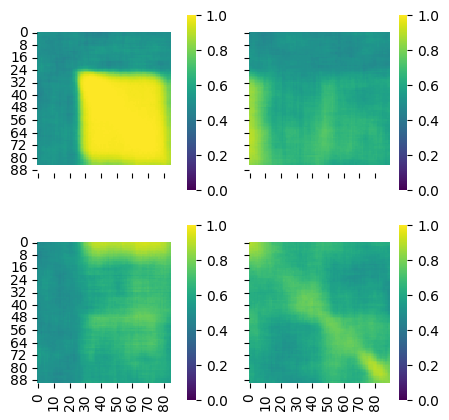

In [9]:
f,ax=plt.subplots(2,2,figsize=(5,5),sharex=True,sharey=True)
A=(np.mean(all_perf,axis=0)/20)[0:85,0:85]
B=(np.mean(all_perf,axis=0)/20)[105:,0:85]
C=(np.mean(all_perf,axis=0)/20)[0:85,105:]
D=(np.mean(all_perf,axis=0)/20)[105:,105:]
sns.heatmap(A,ax=ax[0,0],cmap='viridis',square=True,vmin=0,vmax=1)
sns.heatmap(B,ax=ax[1,0],cmap='viridis',square=True,vmin=0,vmax=1)
sns.heatmap(C,ax=ax[0,1],cmap='viridis',square=True,vmin=0,vmax=1)
sns.heatmap(D,ax=ax[1,1],cmap='viridis',square=True,vmin=0,vmax=1)

In [10]:
test=np.concatenate([np.concatenate([A,C],axis=1),np.concatenate([B,D],axis=1)],axis=0)

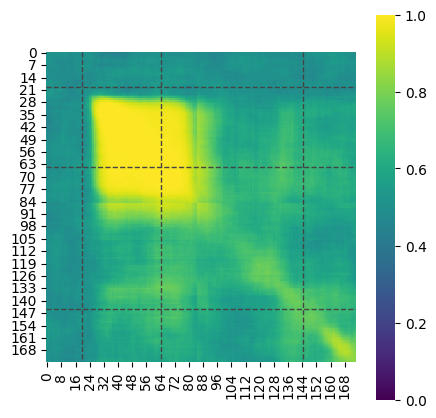

In [11]:
f,ax=plt.subplots(figsize=(5,5))
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(test,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)

#ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)
# ax.set_yticks(ticks)
# ax.set_xticks(ticks)
# ax.set_yticklabels(label_ticks)
# ax.set_xticklabels(label_ticks)

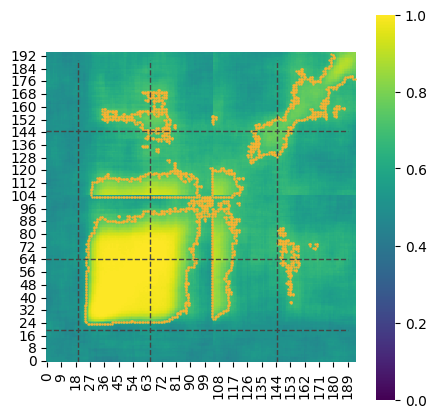

In [15]:
f,ax=plt.subplots(figsize=(5,5))
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(np.mean(all_perf,axis=0)/20,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
xx,yy=define_contour_latencies(np.sum(np.array(all_perf)>10,axis=0), thresh=190)

ax.scatter(xx,yy,s=0.5,color = '#F9B233')
ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)
# ax.set_yticks(ticks)
# ax.set_xticks(ticks)
# ax.set_yticklabels(label_ticks)
# ax.set_xticklabels(label_ticks)

In [3]:
def define_contour_latencies(data, thresh):
        
    X,Y = np.where(data>=thresh)
    A=np.zeros(data.shape)
    A[X,Y]=1
    Ya,Xa    =   np.where(np.abs(np.diff(A, axis=0))!=0)
    Yb,Xb    =   np.where(np.abs(np.diff(A, axis=1))!=0)
    Yy  =   np.concatenate([Ya, Yb])
    Xx  =   np.concatenate([Xa, Xb])
    return Xx,Yy

In [23]:
save = False
im_format='svg'

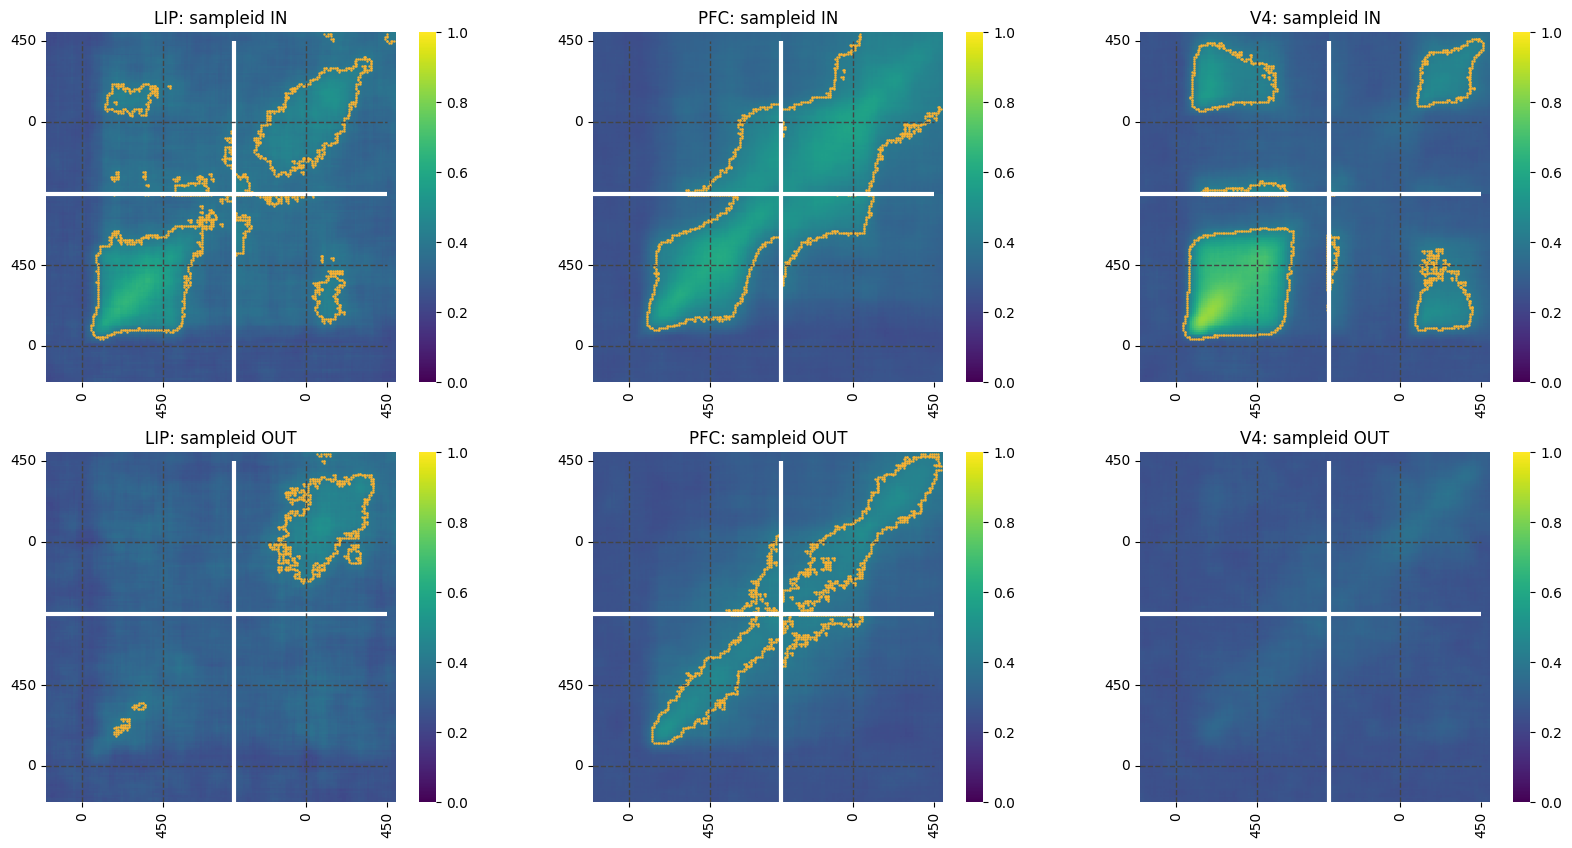

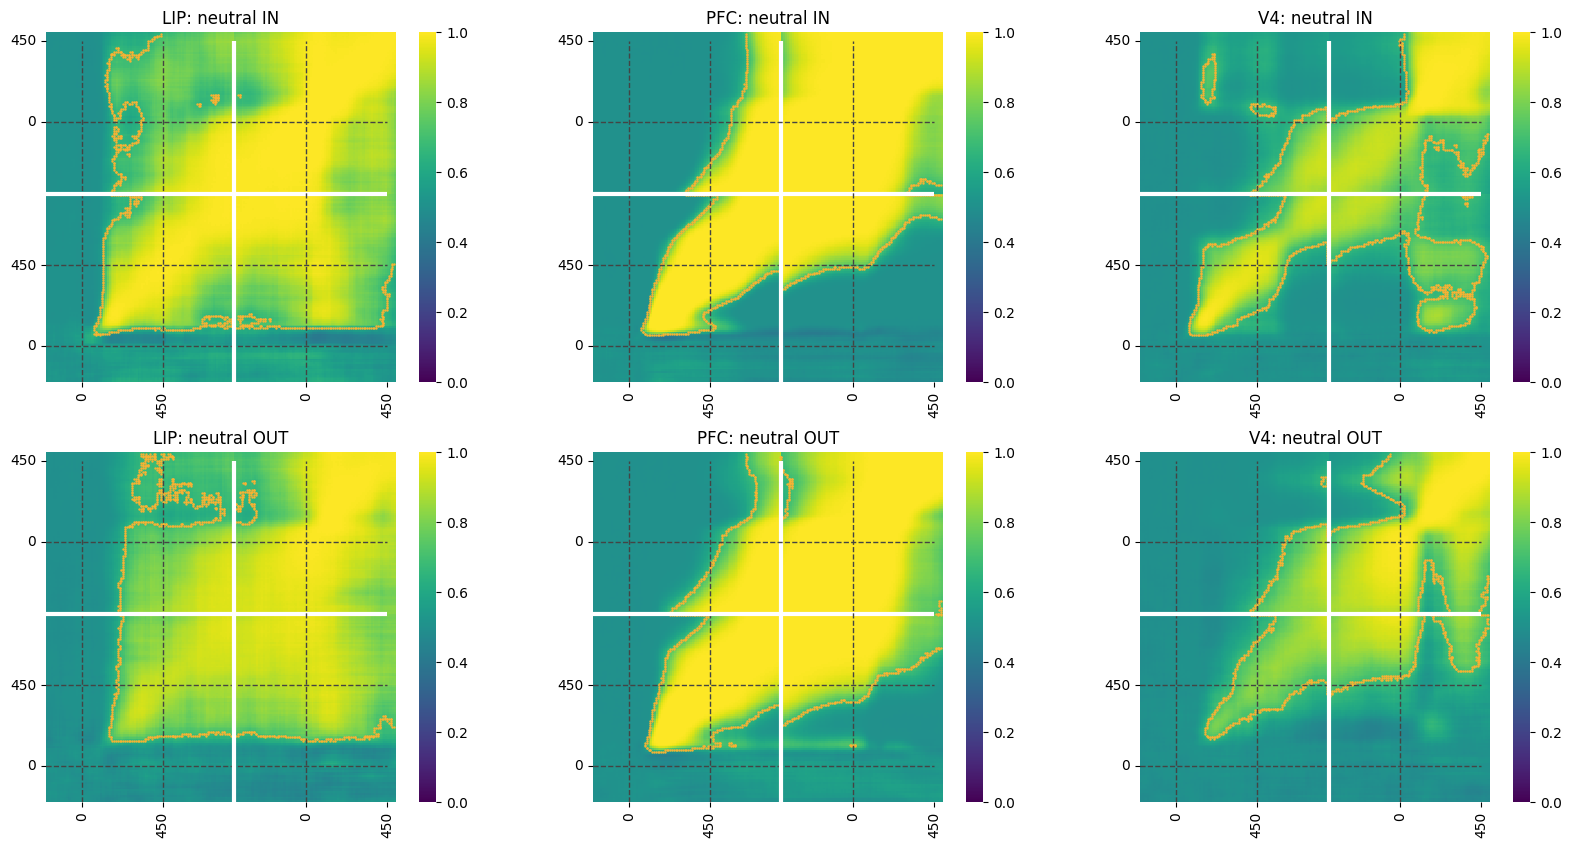

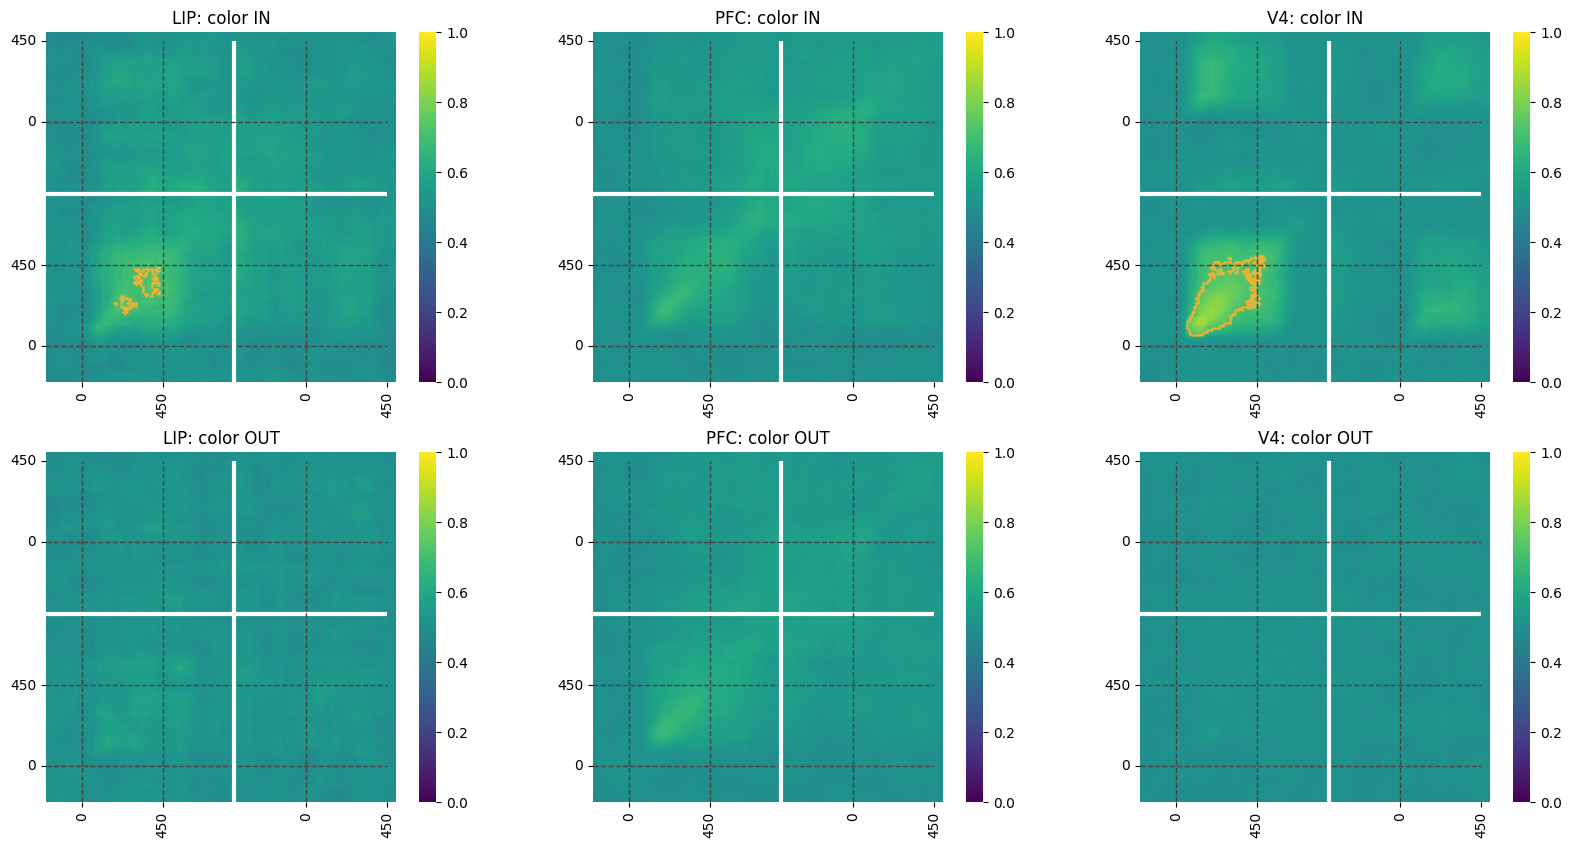

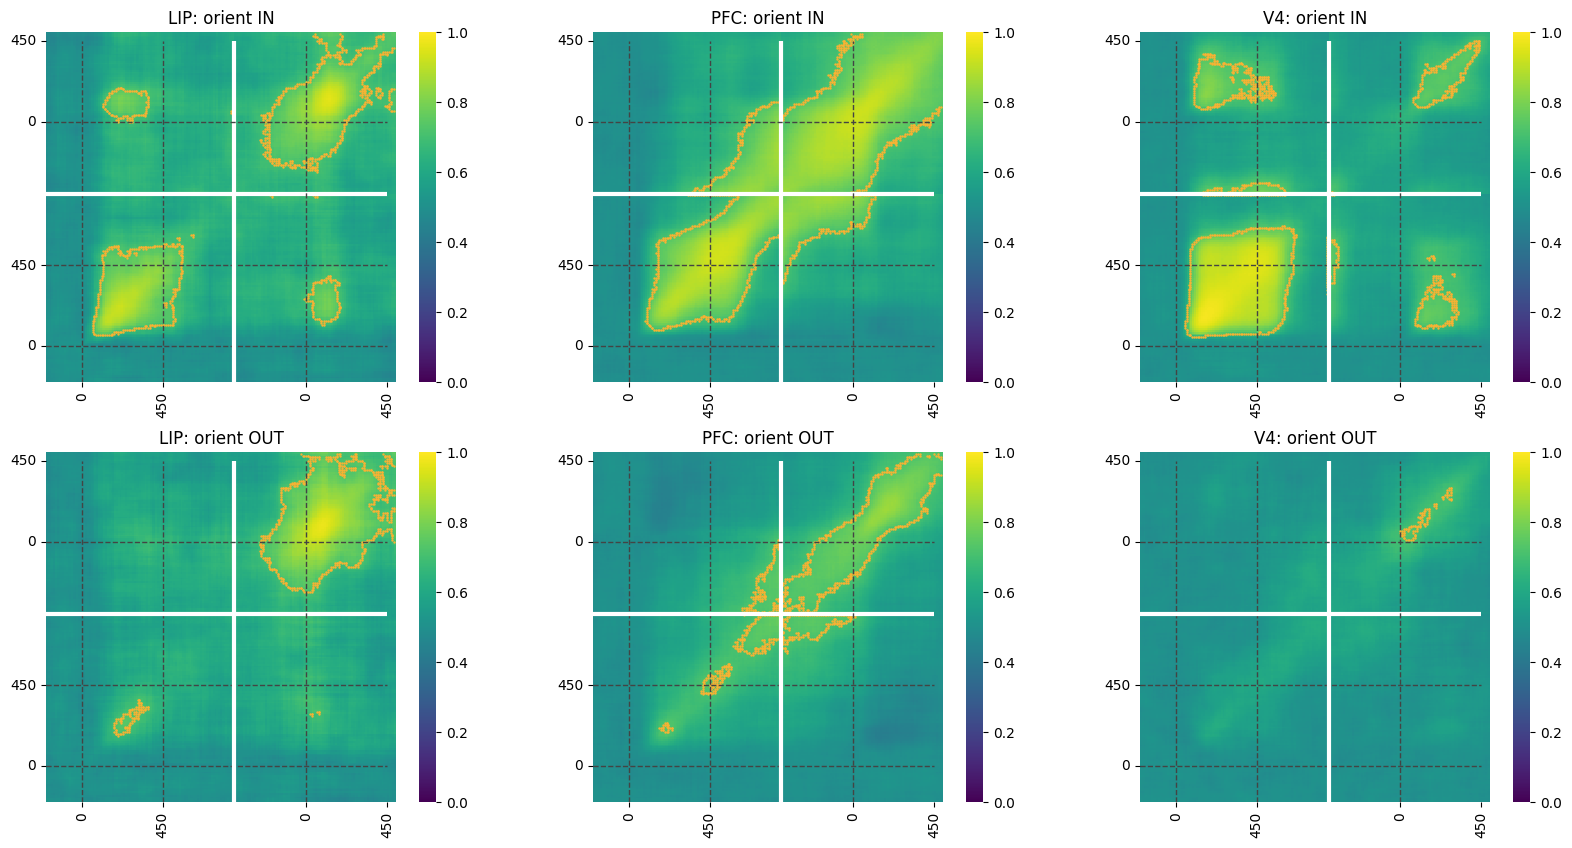

In [198]:
list_todecode = np.array([['neutral','sampleid','color'],['orient','sampleid','color']])
list_areas = np.array([['lip','pfc','v4'],['lip','pfc','v4']])
list_rfpos = np.array([['in_rf','in_rf','in_rf'],['out_rf','out_rf','out_rf']])
date = '2024_09_09_09_13_32'
for to_decode in ['sampleid','neutral','color','orient']:
    totaltests =20
    if to_decode=='sampleid':totaltests=40
    ticks= [20,65,145,190]
    label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
    f,ax=plt.subplots(2,3,figsize=(20,10))
    for j in range(2):
        for i in range(3):
            #to_decode = list_todecode[j,i]
            area = list_areas[j,i]
            rfpos = list_rfpos[j,i]
            res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/in_out_480cells/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
            xx,yy=define_contour_latencies(np.sum(res.perf>10,axis=0), thresh=950)
            sns.heatmap(np.mean(res.perf,axis=0)/totaltests,ax=ax[j,i],cmap='viridis',square=True,vmin=0,vmax=1)
            ax[j,i].scatter(xx,yy,s=0.5,color = '#F9B233')
            ax[j,i].axes.invert_yaxis()
            ax[j,i].vlines([20,65],0,190,'#444444','--',linewidth=1)
            ax[j,i].hlines([20,65],0,190,'#444444','--',linewidth=1)
            ax[j,i].vlines([105],0,190,'white',linewidth=3)
            ax[j,i].hlines([105],0,190,'white',linewidth=3)
            ax[j,i].vlines([145],0,190,'#444444','--',linewidth=1)
            ax[j,i].hlines([145],0,190,'#444444','--',linewidth=1)
            ax[j,i].set_yticks(ticks)
            ax[j,i].set_xticks(ticks)
            ax[j,i].set_yticklabels(label_ticks)
            ax[j,i].set_xticklabels(label_ticks)
            ax[j,i].set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')
    if save:
        f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")

In [241]:
save = True
im_format='pdf'

In [244]:
list_todecode = np.array(['neutral','sampleid','color'])
list_areas = np.array(['lip','pfc','v4'])
list_rfpos = np.array(['contra_rf','contra_rf','contra_rf'])

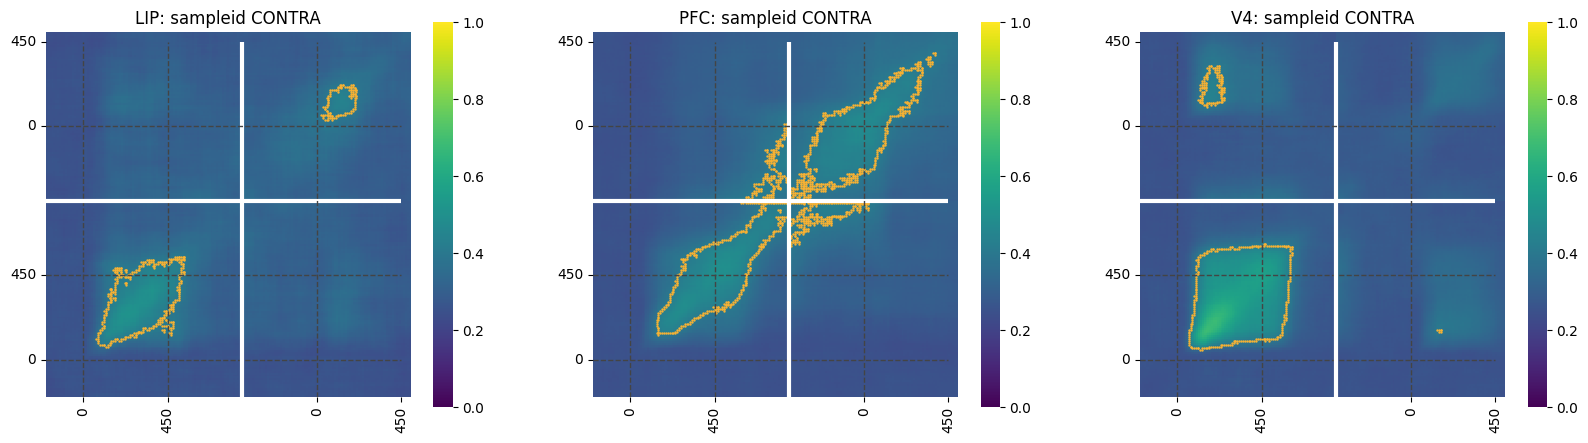

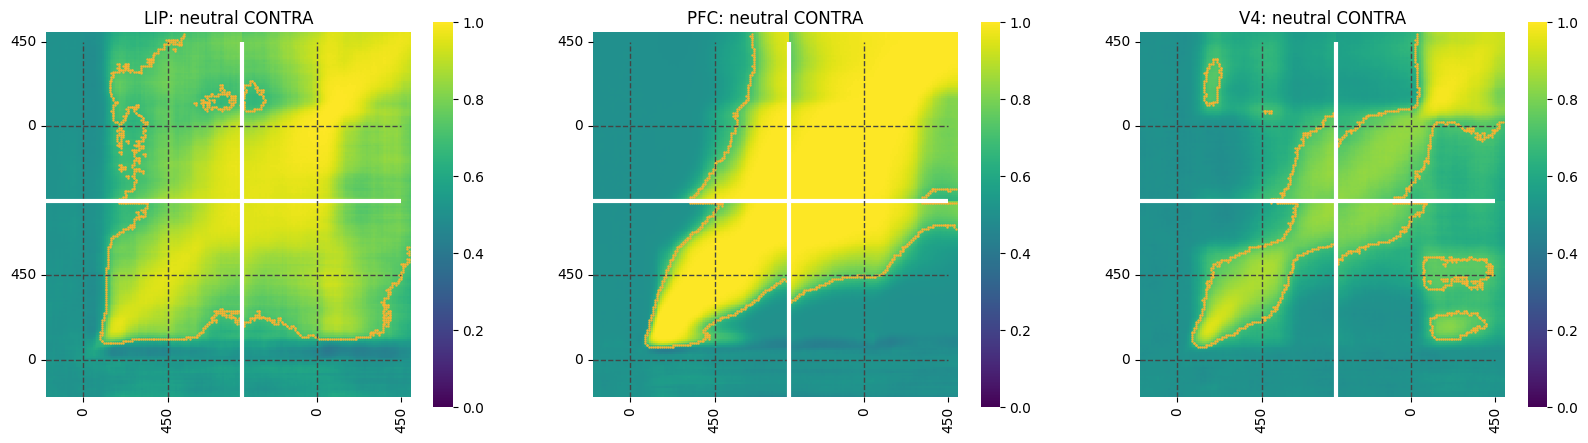

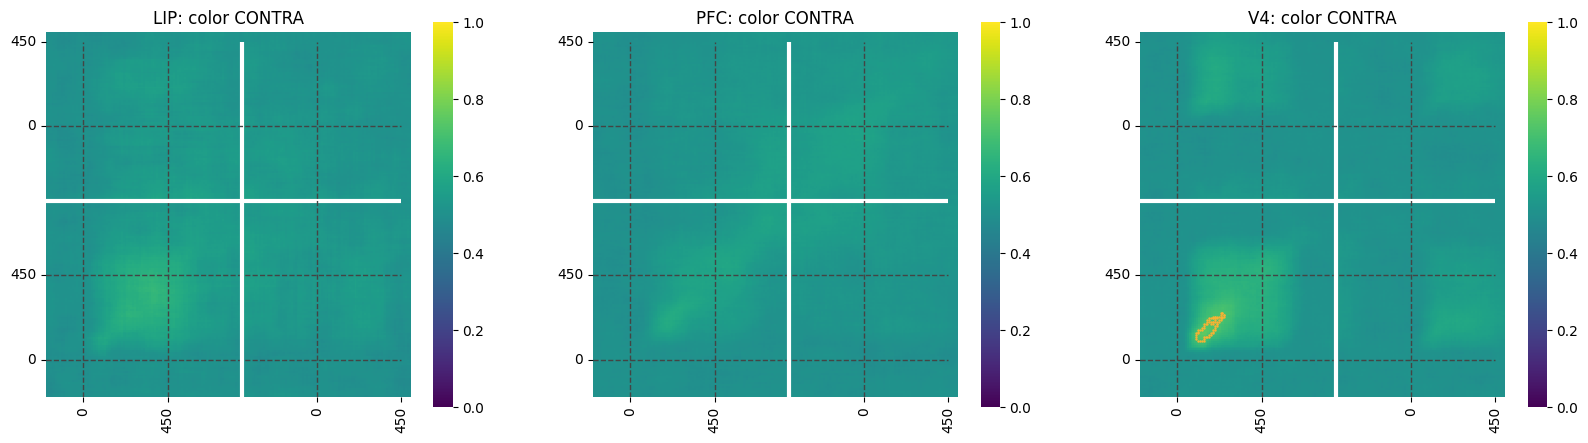

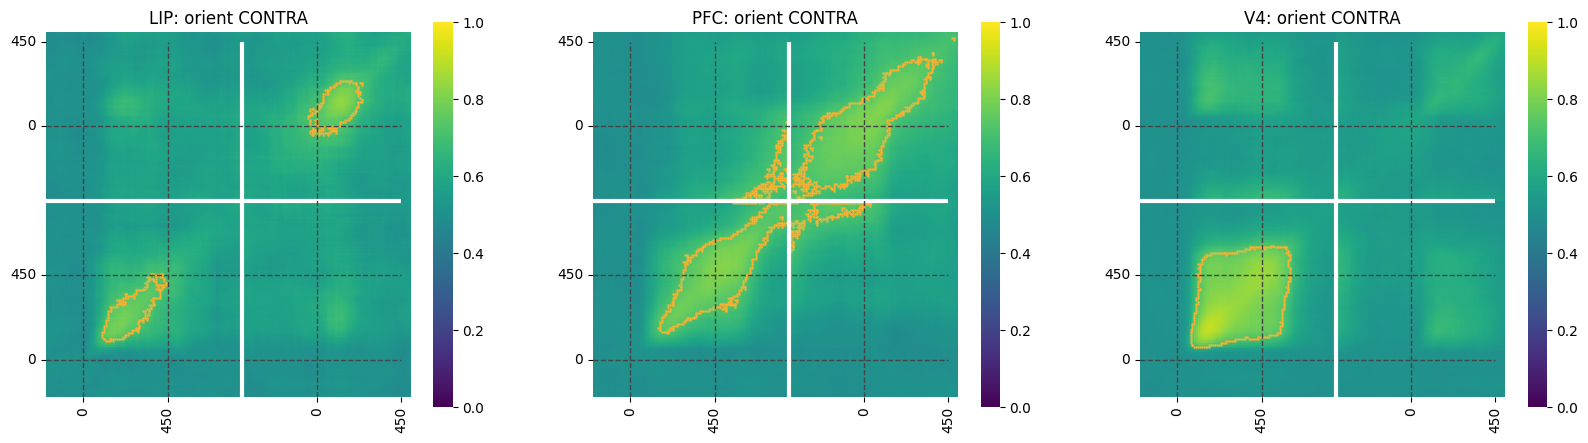

In [245]:
date = '2024_09_08_20_50_20'
for to_decode in ['sampleid','neutral','color','orient']:
    totaltests =20
    if to_decode=='sampleid':totaltests=40
    ticks= [20,65,145,190]
    label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
    f,ax=plt.subplots(1,3,figsize=(20,5))

    for i in range(3):
        area = list_areas[i]
        rfpos = list_rfpos[i]
        res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/contra_480cells/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
        xx,yy=define_contour_latencies(np.sum(res.perf>10,axis=0), thresh=950)
        sns.heatmap(np.mean(res.perf,axis=0)/totaltests,ax=ax[i],cmap='viridis',square=True,vmin=0,vmax=1)
        ax[i].scatter(xx,yy,s=0.5,color = '#F9B233')
        ax[i].axes.invert_yaxis()
        ax[i].vlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[i].hlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[i].vlines([105],0,190,'white',linewidth=3)
        ax[i].hlines([105],0,190,'white',linewidth=3)
        ax[i].vlines([145],0,190,'#444444','--',linewidth=1)
        ax[i].hlines([145],0,190,'#444444','--',linewidth=1)
        ax[i].set_yticks(ticks)
        ax[i].set_xticks(ticks)
        ax[i].set_yticklabels(label_ticks)
        ax[i].set_xticklabels(label_ticks)
        ax[i].set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')
    if save:
        f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")

In [199]:
plt.close()

### plot diagonal

In [12]:
list_areas = np.array([['lip','pfc','v4'],['lip','pfc','v4']])
list_rfpos = np.array([['in_rf','in_rf','in_rf'],['out_rf','out_rf','out_rf']])

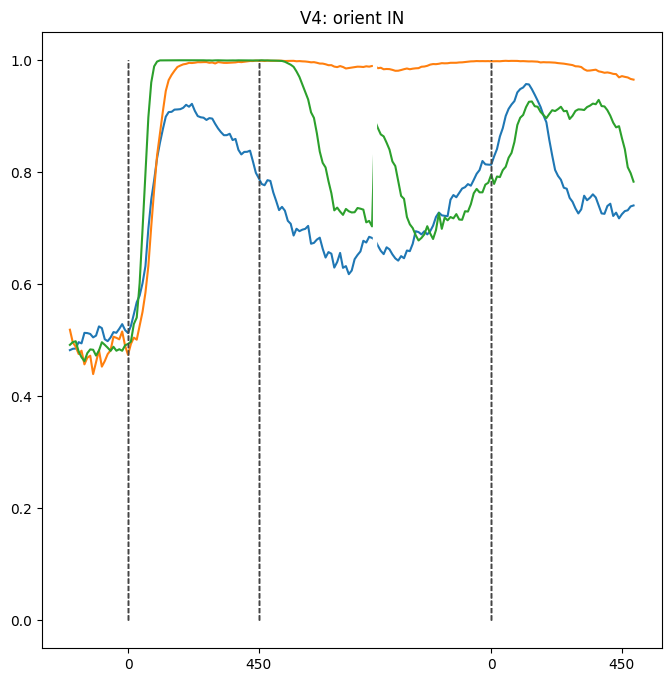

In [13]:
to_decode ='orient'
date = '2024_08_29_15_43_20'
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
f,ax=plt.subplots(figsize=(8,8))
for j in range(1):
    for i in range(3):
        #to_decode = list_todecode
        area = list_areas[j,i]
        rfpos = list_rfpos[j,i]
        res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
        ax.plot(np.diag(np.mean(res.perf,axis=0)))
        ax.vlines([20,65],0,1,'#444444','--',linewidth=1)
        ax.vlines([105],0,1,'white',linewidth=3)
        ax.vlines([145],0,1,'#444444','--',linewidth=1)
        ax.set_xticks(ticks)
        ax.set_xticklabels(label_ticks)
        ax.set_title(f'{to_decode} ')
if save:
    f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")

### Individual plots

In [4]:
def plot_grid_heatmap(mean_data,lat_data):
    xt_t = [40,85]
    xt_s = [20,65]
    label_t = ['0','450']
    label_s = ['0','450']

    samp_limit=20+65
    test_limit=105
    sample_r=int(samp_limit/10)
    test_r=int(test_limit/10)
    total_dim=(sample_r+test_r+1, sample_r+test_r+5)
    panel_dim=sample_r+test_r+1+5

    imcb0= plt.subplot2grid(shape=total_dim,  loc=(0, sample_r+test_r), colspan=1, rowspan=sample_r+test_r)

    im00 = plt.subplot2grid(shape=total_dim, loc=(0, 0), colspan=sample_r, rowspan=test_r)
    xx,yy=define_contour_latencies(lat_data[test_limit:,:samp_limit], thresh=950)
    sns.heatmap(mean_data[test_limit:,:samp_limit],ax=im00,cmap='viridis',vmin=0,vmax=1,cbar_ax=imcb0, linewidth=0,rasterized=True)
    im00.scatter(xx,yy,s=0.5,color = '#F9B233')
    im00.axes.invert_yaxis()

    im01 = plt.subplot2grid(shape=total_dim, loc=(0, sample_r), colspan=test_r, rowspan=test_r)
    xx,yy=define_contour_latencies(lat_data[test_limit:,test_limit:], thresh=950)
    sns.heatmap(mean_data[test_limit:,test_limit:],ax=im01,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im01.scatter(xx,yy,s=0.5,color = '#F9B233')
    im01.axes.invert_yaxis()


    im10 = plt.subplot2grid(shape=total_dim, loc=(test_r, 0), colspan=sample_r, rowspan=sample_r)
    xx,yy=define_contour_latencies(lat_data[:samp_limit,:samp_limit], thresh=950)
    sns.heatmap(mean_data[:samp_limit,:samp_limit],ax=im10,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im10.scatter(xx,yy,s=0.5,color = '#F9B233')
    im10.axes.invert_yaxis()

    im11 = plt.subplot2grid(shape=total_dim, loc=(test_r, sample_r), colspan=test_r, rowspan=sample_r)
    xx,yy=define_contour_latencies(lat_data[:samp_limit,test_limit:], thresh=950)
    sns.heatmap(mean_data[:samp_limit,test_limit:],ax=im11,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im11.scatter(xx,yy,s=0.5,color = '#F9B233')
    im11.axes.invert_yaxis()

    im00.vlines(xt_s,0,200,'#444444','--',linewidth=1)
    im00.hlines(xt_t,0,200,'#444444','--',linewidth=1)
    im10.vlines(xt_s,0,200,'#444444','--',linewidth=1)
    im10.hlines(xt_s,0,200,'#444444','--',linewidth=1)
    im11.vlines(xt_t,0,200,'#444444','--',linewidth=1)
    im11.hlines(xt_s,0,200,'#444444','--',linewidth=1)
    im01.vlines(xt_t,0,200,'#444444','--',linewidth=1)
    im01.hlines(xt_t,0,200,'#444444','--',linewidth=1)

    im00.set_xticks([])
    im00.set_yticks(xt_t)
    im01.set_xticks([])
    im01.set_yticks([])
    im10.set_xticks(xt_s)
    im10.set_yticks(xt_s)
    im11.set_xticks(xt_t)
    im11.set_yticks([])

    im00.set_yticklabels(label_t)
    im10.set_xticklabels(label_s)
    im10.set_yticklabels(label_s)
    im11.set_xticklabels(label_t)
    im00.set_yticklabels(label_t)
    im10.set_xticklabels(label_s)
    im10.set_yticklabels(label_s)
    im11.set_xticklabels(label_t)


    return [im00, im01, im10, im11, imcb0]

In [5]:
save = False
im_format='pdf'

Text(0.5, 0.98, 'LIP: orient OUT')

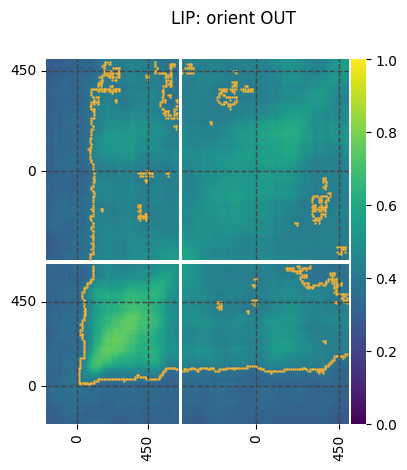

In [24]:
# res = Results.from_python_hdf5("//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/LOSADA/Users/losadac/decoder/.percentile_with_nonzero/lip/q0.5q99.5c0.001/sampleid/q0.5q99.5_474cells_c0.001_test_sampleid.h5")

# data=res.perf.transpose(0,2,1)
# lat_data = np.sum(data>10,axis=0)
# mean_data = np.mean(data,axis=0)/40
# # Create and capture fig1
# fig = plt.figure(figsize=(5, 5))
# plot_grid_heatmap(mean_data,lat_data)
# fig.suptitle(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')

In [6]:
date = '2024_10_04_15_49_46'#lip:'2024_10_04_14_20_10'#lip all tr: '2024_10_04_13_38_31'# pfc:'2024_10_04_15_49_46'
for rfpos in ['in_rf','out_rf']:
    path=(f'//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/percentile_with_nonzero/{date}/{rfpos}')
    for area in ['pfc']:
        for to_decode in ['sampleid','neutral','color','orient']:   
            totatest = 20
            if to_decode=='sampleid':totatest=40
            res = Results.from_python_hdf5(f'{path}/{to_decode}/{area}/0.001/performance_decoder.h5')

            data=res.perf.transpose(0,2,1)
            lat_data = np.sum(data>10,axis=0)
            mean_data = np.mean(data,axis=0)/totatest
            # Create and capture fig1
            fig = plt.figure(figsize=(5, 5))
            plot_grid_heatmap(mean_data,lat_data)
            fig.suptitle(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')
            if save:
                fig.savefig(f'{path}/{area}_{to_decode}.{im_format}',format=im_format)
                plt.close()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/percentile_with_nonzero/*/in_rf/sampleid/pfc/0.001/performance_decoder.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]

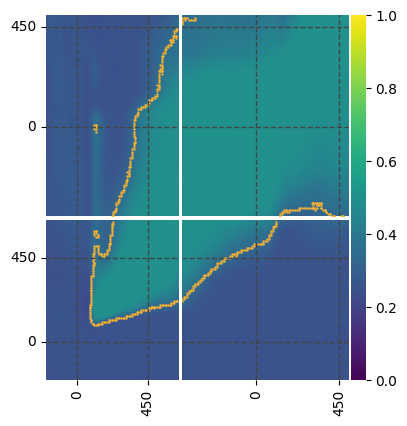

In [234]:
data=res.perf.transpose(0,2,1)
lat_data = np.sum(data>10,axis=0)
mean_data = np.mean(data,axis=0)/40
# Create and capture fig1
fig1 = plt.figure(figsize=(5, 5))
plot_grid_heatmap(mean_data,lat_data)

In [18]:
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/percentile_with_nonzero/300_cells/2024_10_07_12_45_32

'//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/percentile_with_nonzero/2024_10_04_15_49_46/in_rf/color/pfc/0.001'

In [14]:
path

'//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/percentile_with_nonzero/300_cells/*/out_rf/sampleid/pfc/0.001'

In [20]:
save=True
save_format='svg'
svc_c=0.001
for rfpos in ['in_rf','out_rf']:
    for area in ['lip','v4','pfc']:
        print(area)
        for to_decode in ["orient","sampleid", "neutral", "color"]:
            print(to_decode)
            path=(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/percentile_with_nonzero/300_cells/*/{rfpos}/{to_decode}/{area}/{svc_c}')
            path_list = glob.glob(path+'/*.h5')
            totatest = 20
            if to_decode=='sampleid':totatest=40
            for i_path in path_list:
                res = Results.from_python_hdf5(i_path)
                data=res.perf.transpose(0,2,1)
                lat_data = np.sum(data>10,axis=0)
                mean_data = np.mean(data,axis=0)/totatest
                # Create and capture fig1
                fig = plt.figure(figsize=(5, 5))
                plot_grid_heatmap(mean_data,lat_data)
                fig.suptitle(f"{area} {res.n_neurons}")
                if save:
                    sp_path = os.path.normpath(i_path)
                    path = "/".join(sp_path.split(os.sep)[:-1])
                    savepath = path + f"/{save_format}/{res.n_neurons}cells_c{svc_c}_test_{to_decode}.{save_format}"
                    if not os.path.exists(f"{path}/{save_format}"):
                        os.makedirs(f"{path}/{save_format}")
                    fig.savefig(savepath,format=save_format,bbox_inches="tight")
                    plt.close()

lip
orient
sampleid
neutral
color
v4
orient
sampleid
neutral
color
pfc
orient
sampleid
neutral
color
lip
orient
sampleid
neutral
color
v4
orient
sampleid
neutral
color
pfc
orient
sampleid
neutral
color


In [11]:
res.n_neurons

1962